In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas
import sys
import scipy
sys.path.append('/Users/ruby/EoR/pyuvdata')
from pyuvdata import UVData
import scipy.optimize
import scipy.stats

In [2]:
path = '/Users/ruby/EoR/compact_redundant_array_sim_May2020'
# Load data from pyuvsim simulation:
data_sim = UVData()
data_sim.read_uvh5('{}/square_grid_sim__results.uvh5'.format(path))

# Inflate data
print(np.shape(data_sim.baseline_array))
data_sim.inflate_by_redundancy()
print(np.shape(data_sim.baseline_array))

# Remove autos
data_sim.select(ant_str='cross')
# Use only XX polarizations
data_sim.select(polarizations=[-5])

# Convert baselines to have u>0
data_sim.conjugate_bls(convention='u>0', use_enu=False, uvw_tol=0.01)

true_visibilities = data_sim.data_array[:,0,0,0]

Telescope square_grid is not in known_telescopes.


(61,)
(666,)


In [3]:
baseline_groups, vec_bin_centers, lengths, conjugates = data_sim.get_redundancies(
    tol=0.1, use_antpos=False, include_conjugates=True, include_autos=True, conjugate_bls=False
)

# Create the baseline covariance matrix
baseline_cov_array = np.diag(np.full(np.shape(baseline_groups)[0], 1.))
min_bl_length = 14.
tolerance = .01
for bl_1 in range(np.shape(baseline_groups)[0]):
    for bl_2 in [ind for ind in range(np.shape(baseline_groups)[0]) if ind != bl_1]:
        bl_separation_sq = (
            (vec_bin_centers[bl_1, 0]-vec_bin_centers[bl_2, 0])**2
            + (vec_bin_centers[bl_1, 1]-vec_bin_centers[bl_2, 1])**2
        )
        if (min_bl_length-tolerance)**2 <= bl_separation_sq <= (min_bl_length+tolerance)**2:
            baseline_cov_array[bl_1, bl_2] = 0.1617
        elif 2*(min_bl_length-tolerance)**2 <= bl_separation_sq <= 2*(min_bl_length+tolerance)**2:
            baseline_cov_array[bl_1, bl_2] = 0.0176
# Invert the matrix
baseline_cov_inv = np.linalg.inv(baseline_cov_array)

# Create the A matrix
a_mat = np.zeros((data_sim.Nbls, np.shape(baseline_groups)[0]))
for red_group in range(np.shape(baseline_groups)[0]):
    for baseline in baseline_groups[red_group]:
        a_mat[np.where(data_sim.baseline_array == baseline)[0], red_group] = 1
        
# Create gains expand matrices
gains_exp_mat_1 = np.zeros((data_sim.Nbls, data_sim.Nants_data), dtype=np.int)
gains_exp_mat_2 = np.zeros((data_sim.Nbls, data_sim.Nants_data), dtype=np.int)
for baseline in range(data_sim.Nbls):
    gains_exp_mat_1[baseline, data_sim.ant_1_array[baseline]] = 1
    gains_exp_mat_2[baseline, data_sim.ant_2_array[baseline]] = 1

In [4]:
def cost_function(
    x, 
    N_red_baselines, Nants, baseline_cov_inv, model_visibilities, a_mat,
    gains_exp_mat_1, gains_exp_mat_2, data_visibilities, data_stddev, model_stddev
):

    fitted_visibilities = x[-2*N_red_baselines:-N_red_baselines]+1j*x[-N_red_baselines:]
    gains = x[:Nants]+1j*x[Nants:2*Nants]
    
    vis_diff = fitted_visibilities-model_visibilities
    prior = np.abs(np.dot(np.matmul(np.conj(vis_diff), baseline_cov_array), vis_diff))
    
    fitted_visibilities_expanded = np.matmul(a_mat, fitted_visibilities)
    gains_expanded = np.matmul(gains_exp_mat_1, gains)*np.matmul(gains_exp_mat_2, np.conj(gains))
    prob = np.sum(np.abs(data_visibilities - gains_expanded*fitted_visibilities_expanded)**2)
    
    return prob/data_stddev**2+prior/model_stddev**2

In [5]:
# Create model visibilities and ensure correct ordering
data_compact = data_sim.copy()
data_compact.compress_by_redundancy()
model_visibilities_no_noise = np.zeros(np.shape(baseline_groups)[0], dtype=np.complex_)
uvw_match_tolerance = 1e-12
for red_group in range(np.shape(baseline_groups)[0]):
    found_group = False
    for red_group_2 in range(np.shape(baseline_groups)[0]):
        if np.abs(np.sum(data_compact.uvw_array[red_group]-vec_bin_centers[red_group_2])) < uvw_match_tolerance:
            model_visibilities_no_noise[red_group] = data_compact.data_array[red_group_2, 0, 0, 0]
            found_group = True
            break
    if not found_group:
        print('ERROR: Visibility not found.')

model_stddev = .2
model_visibilities = (
    model_visibilities_no_noise 
    + np.random.normal(0, model_stddev, np.shape(model_visibilities_no_noise)) 
    + 1j*np.random.normal(0, model_stddev, np.shape(model_visibilities_no_noise))
)

# Initialize the gains to 1
gains_initialize = np.full(data_sim.Nants_data, 1.+0.j)
# Expand the initialized values
x0 = np.concatenate((
    np.real(gains_initialize), np.imag(gains_initialize),
    np.real(model_visibilities), np.imag(model_visibilities)
))

0.0041629233452904575
0.056044811846499606


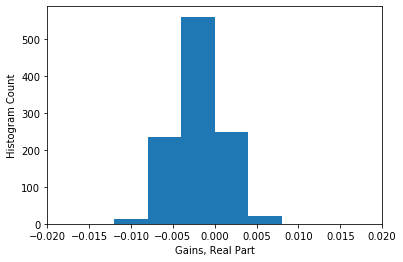

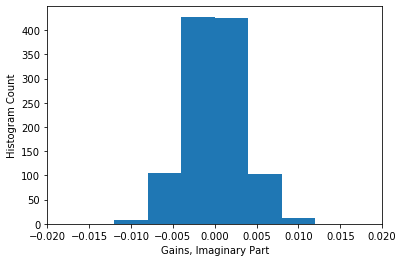

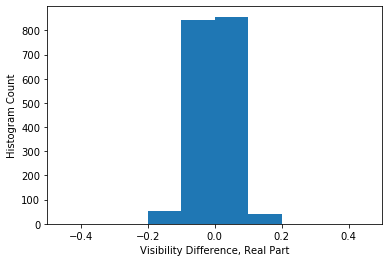

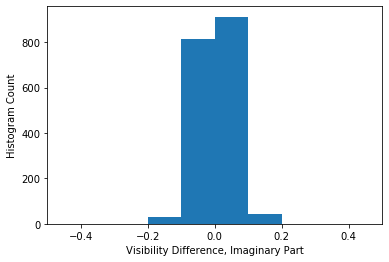

In [6]:
n_trials=30
method = 'Powell'
maxiter = 100000
data_stddev = .1

gain_vals = np.zeros((data_sim.Nants_data, n_trials), dtype=np.complex_)
vis_diff_vals = np.zeros((np.shape(baseline_groups)[0], n_trials), dtype=np.complex_)

for trial in range(n_trials):
    data_visibilities = (
        data_sim.data_array[:,0,0,0] 
        + np.random.normal(0, data_stddev, np.shape(data_sim.data_array[:,0,0,0])) 
        + 1j*np.random.normal(0, data_stddev, np.shape(data_sim.data_array[:,0,0,0]))
    )
    
    result = scipy.optimize.minimize(
        cost_function, x0, 
        args=(
            np.shape(baseline_groups)[0], data_sim.Nants_data, baseline_cov_inv, 
            model_visibilities, a_mat, gains_exp_mat_1, gains_exp_mat_2, data_visibilities, data_stddev, model_stddev
        ),
        method=method, options={'maxiter':maxiter}
    )
    #print(result.message)
    gains_fit = result.x[:data_sim.Nants_data]+1j*result.x[data_sim.Nants_data:2*data_sim.Nants_data]
    # Ensure that the average angle is zero
    avg_angle = np.arctan2(np.mean(np.sin(np.angle(gains_fit))), np.mean(np.cos(np.angle(gains_fit))))
    gains_fit *= np.cos(avg_angle) - 1j*np.sin(avg_angle)
    gain_vals[:, trial] = gains_fit-1
    vis_fit = result.x[-2*np.shape(baseline_groups)[0]:-np.shape(baseline_groups)[0]]+1j*result.x[-np.shape(baseline_groups)[0]:]
    vis_fit_diff = vis_fit-model_visibilities_no_noise
    vis_diff_vals[:, trial] = vis_fit_diff

print(np.mean(np.abs(gain_vals)))
print(np.mean(np.abs(vis_diff_vals)))

plot_range = .02
nbins = 10
bins = np.linspace(-plot_range, plot_range, num=nbins+1)

plt.hist(np.real(gain_vals).flatten(), bins=bins)
plt.xlabel('Gains, Real Part')
plt.ylabel('Histogram Count')
plt.xlim(-plot_range,plot_range)
plt.show()

plt.hist(np.imag(gain_vals).flatten(), bins=bins)
plt.xlabel('Gains, Imaginary Part')
plt.ylabel('Histogram Count')
plt.xlim(-1*plot_range, plot_range)
plt.show()

plot_range = .5
bins = np.linspace(-plot_range, plot_range, num=nbins+1)

plt.hist(np.real(vis_diff_vals).flatten(), bins=bins)
plt.xlabel('Visibility Difference, Real Part')
plt.ylabel('Histogram Count')
plt.xlim(-1*plot_range, plot_range)
plt.show()

plt.hist(np.imag(vis_diff_vals).flatten(), bins=bins)
plt.xlabel('Visibility Difference, Imaginary Part')
plt.ylabel('Histogram Count')
plt.xlim(-1*plot_range, plot_range)
plt.show()

0.003995337749069865
0.056703062184262354


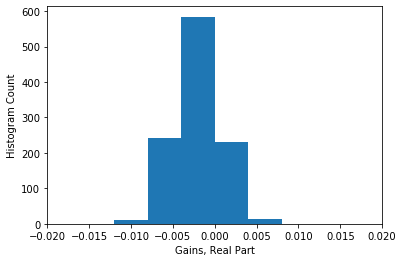

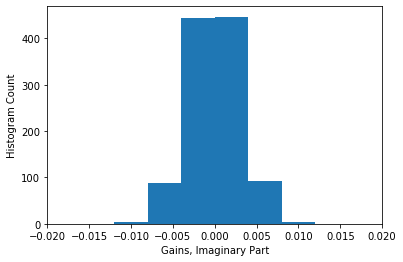

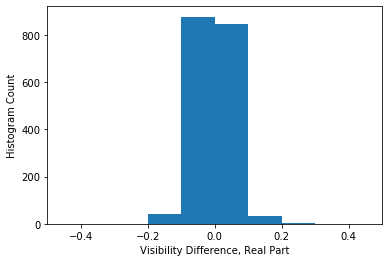

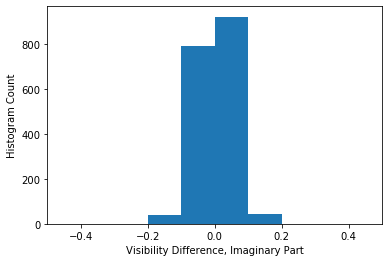

In [7]:
n_trials=30
method = 'Powell'
maxiter = 100000
data_stddev = .1

gain_vals = np.zeros((data_sim.Nants_data, n_trials), dtype=np.complex_)
vis_diff_vals = np.zeros((np.shape(baseline_groups)[0], n_trials), dtype=np.complex_)

for trial in range(n_trials):
    data_visibilities = (
        data_sim.data_array[:,0,0,0] 
        + np.random.normal(0, data_stddev, np.shape(data_sim.data_array[:,0,0,0])) 
        + 1j*np.random.normal(0, data_stddev, np.shape(data_sim.data_array[:,0,0,0]))
    )
    
    result = scipy.optimize.minimize(
        cost_function, x0, 
        args=(
            np.shape(baseline_groups)[0], data_sim.Nants_data, baseline_cov_inv, 
            model_visibilities, a_mat, gains_exp_mat_1, gains_exp_mat_2, data_visibilities, data_stddev, model_stddev*10000
        ),
        method=method, options={'maxiter':maxiter}
    )
    #print(result.message)
    gains_fit = result.x[:data_sim.Nants_data]+1j*result.x[data_sim.Nants_data:2*data_sim.Nants_data]
    # Ensure that the average angle is zero
    avg_angle = np.arctan2(np.mean(np.sin(np.angle(gains_fit))), np.mean(np.cos(np.angle(gains_fit))))
    gains_fit *= np.cos(avg_angle) - 1j*np.sin(avg_angle)
    gain_vals[:, trial] = gains_fit-1
    vis_fit = result.x[-2*np.shape(baseline_groups)[0]:-np.shape(baseline_groups)[0]]+1j*result.x[-np.shape(baseline_groups)[0]:]
    vis_fit_diff = vis_fit-model_visibilities_no_noise
    vis_diff_vals[:, trial] = vis_fit_diff

print(np.mean(np.abs(gain_vals)))
print(np.mean(np.abs(vis_diff_vals)))

plot_range = .02
nbins = 10
bins = np.linspace(-plot_range, plot_range, num=nbins+1)

plt.hist(np.real(gain_vals).flatten(), bins=bins)
plt.xlabel('Gains, Real Part')
plt.ylabel('Histogram Count')
plt.xlim(-plot_range,plot_range)
plt.show()

plt.hist(np.imag(gain_vals).flatten(), bins=bins)
plt.xlabel('Gains, Imaginary Part')
plt.ylabel('Histogram Count')
plt.xlim(-1*plot_range, plot_range)
plt.show()

plot_range = .5
bins = np.linspace(-plot_range, plot_range, num=nbins+1)

plt.hist(np.real(vis_diff_vals).flatten(), bins=bins)
plt.xlabel('Visibility Difference, Real Part')
plt.ylabel('Histogram Count')
plt.xlim(-1*plot_range, plot_range)
plt.show()

plt.hist(np.imag(vis_diff_vals).flatten(), bins=bins)
plt.xlabel('Visibility Difference, Imaginary Part')
plt.ylabel('Histogram Count')
plt.xlim(-1*plot_range, plot_range)
plt.show()

0.005492685268479054
0.28252811061505895


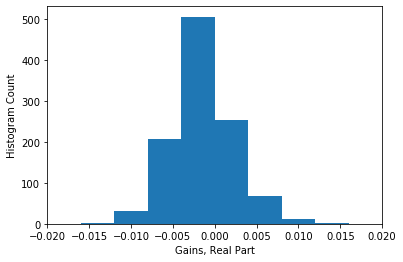

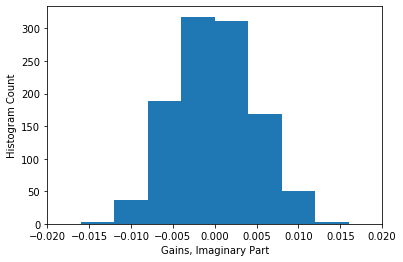

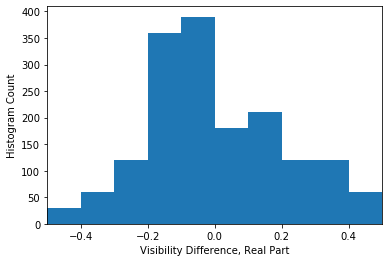

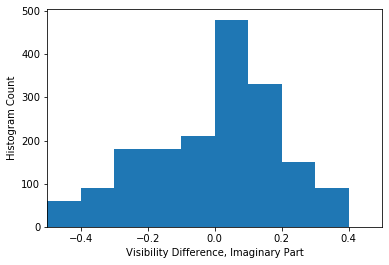

In [8]:
n_trials=30
method = 'Powell'
maxiter = 100000
data_stddev = .1

gain_vals = np.zeros((data_sim.Nants_data, n_trials), dtype=np.complex_)
vis_diff_vals = np.zeros((np.shape(baseline_groups)[0], n_trials), dtype=np.complex_)

for trial in range(n_trials):
    data_visibilities = (
        data_sim.data_array[:,0,0,0] 
        + np.random.normal(0, data_stddev, np.shape(data_sim.data_array[:,0,0,0])) 
        + 1j*np.random.normal(0, data_stddev, np.shape(data_sim.data_array[:,0,0,0]))
    )
    
    result = scipy.optimize.minimize(
        cost_function, x0, 
        args=(
            np.shape(baseline_groups)[0], data_sim.Nants_data, baseline_cov_inv, 
            model_visibilities, a_mat, gains_exp_mat_1, gains_exp_mat_2, data_visibilities, data_stddev, model_stddev/10000
        ),
        method=method, options={'maxiter':maxiter}
    )
    #print(result.message)
    gains_fit = result.x[:data_sim.Nants_data]+1j*result.x[data_sim.Nants_data:2*data_sim.Nants_data]
    # Ensure that the average angle is zero
    avg_angle = np.arctan2(np.mean(np.sin(np.angle(gains_fit))), np.mean(np.cos(np.angle(gains_fit))))
    gains_fit *= np.cos(avg_angle) - 1j*np.sin(avg_angle)
    gain_vals[:, trial] = gains_fit-1
    vis_fit = result.x[-2*np.shape(baseline_groups)[0]:-np.shape(baseline_groups)[0]]+1j*result.x[-np.shape(baseline_groups)[0]:]
    vis_fit_diff = vis_fit-model_visibilities_no_noise
    vis_diff_vals[:, trial] = vis_fit_diff

print(np.mean(np.abs(gain_vals)))
print(np.mean(np.abs(vis_diff_vals)))

plot_range = .02
nbins = 10
bins = np.linspace(-plot_range, plot_range, num=nbins+1)

plt.hist(np.real(gain_vals).flatten(), bins=bins)
plt.xlabel('Gains, Real Part')
plt.ylabel('Histogram Count')
plt.xlim(-plot_range,plot_range)
plt.show()

plt.hist(np.imag(gain_vals).flatten(), bins=bins)
plt.xlabel('Gains, Imaginary Part')
plt.ylabel('Histogram Count')
plt.xlim(-1*plot_range, plot_range)
plt.show()

plot_range = .5
bins = np.linspace(-plot_range, plot_range, num=nbins+1)

plt.hist(np.real(vis_diff_vals).flatten(), bins=bins)
plt.xlabel('Visibility Difference, Real Part')
plt.ylabel('Histogram Count')
plt.xlim(-1*plot_range, plot_range)
plt.show()

plt.hist(np.imag(vis_diff_vals).flatten(), bins=bins)
plt.xlabel('Visibility Difference, Imaginary Part')
plt.ylabel('Histogram Count')
plt.xlim(-1*plot_range, plot_range)
plt.show()

In [9]:
# Load data with missing sources from pyuvsim simulation:
model_sim = UVData()
model_sim.read_uvh5('{}/square_grid_100mjy_sim_results.uvh5'.format(path))

# Remove autos
model_sim.select(ant_str='cross')
# Use only XX polarizations
model_sim.select(polarizations=[-5])

# Convert baselines to have u>0
model_sim.conjugate_bls(convention='u>0', use_enu=False, uvw_tol=0.01)

model_sim_visibilities = np.zeros(np.shape(baseline_groups)[0], dtype=np.complex_)
uvw_match_tolerance = 1e-12
for red_group in range(np.shape(baseline_groups)[0]):
    found_group = False
    for red_group_2 in range(np.shape(baseline_groups)[0]):
        if np.abs(np.sum(model_sim.uvw_array[red_group]-vec_bin_centers[red_group_2])) < uvw_match_tolerance:
            model_sim_visibilities[red_group] = model_sim.data_array[red_group_2, 0, 0, 0]
            found_group = True
            break
    if not found_group:
        print('ERROR: Visibility not found.')

# Initialize the gains to 1
gains_initialize = np.full(data_sim.Nants_data, 1.+0.j)
# Expand the initialized values
x0 = np.concatenate((
    np.real(gains_initialize), np.imag(gains_initialize),
    np.real(model_sim_visibilities), np.imag(model_sim_visibilities)
))

Telescope square_grid is not in known_telescopes.


In [10]:
print(np.mean(np.abs(model_visibilities_no_noise)))

5.575420282504045


0.15679782064777625
0.5030445867414423


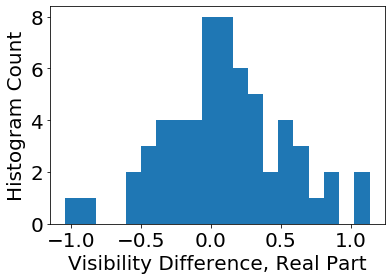

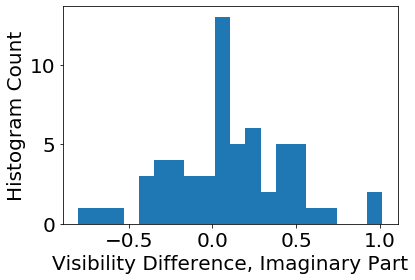

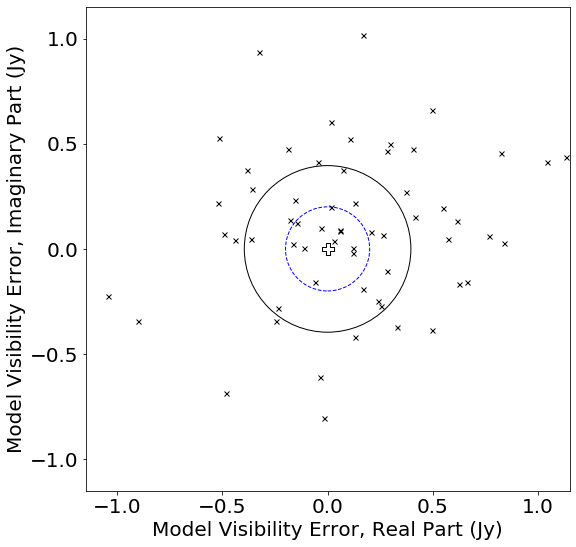

1.1355358052064242
1.0158161355218782


In [28]:
model_stddev_sim = np.mean([
    np.std(np.real(model_sim_visibilities-model_visibilities_no_noise)),
    np.std(np.imag(model_sim_visibilities-model_visibilities_no_noise))
])
print(model_stddev_sim**2)
print(np.mean(np.abs(model_sim_visibilities-model_visibilities_no_noise)))

plt.hist(np.real(model_sim_visibilities-model_visibilities_no_noise).flatten(), bins=20)
plt.xlabel('Visibility Difference, Real Part')
plt.ylabel('Histogram Count')
#plt.xlim(-1*plot_range, plot_range)
plt.show()

plt.hist(np.imag(model_sim_visibilities-model_visibilities_no_noise).flatten(), bins=20)
plt.xlabel('Visibility Difference, Imaginary Part')
plt.ylabel('Histogram Count')
#plt.xlim(-1*plot_range, plot_range)
plt.show()

plt.figure(figsize=[10,8])
plt.plot(
    np.real(model_sim_visibilities-model_visibilities_no_noise).flatten(), 
    np.imag(model_sim_visibilities-model_visibilities_no_noise).flatten(),
    'x', color='black', markersize=5
)
plt.axis('square')
plt.xlim(-1.15,1.15)
plt.ylim(-1.15,1.15)
#cont = plt.contour(bins, bins, percent_plot, levels=[.5,.9], colors='white', linestyles=['solid','dashed'], linewidths=1)
plt.scatter([0],[0],marker='P',color='white',edgecolors='black',s=150)
circle = plt.Circle((0, 0), model_stddev_sim, fill=False, color='black')
plt.gcf().gca().add_artist(circle)
circle = plt.Circle((0, 0), data_stddev, fill=False, color='blue', linestyle='dashed')
plt.gcf().gca().add_artist(circle)
#plt.clabel(cont, inline=2, fontsize=10)
plt.xlabel('Model Visibility Error, Real Part (Jy)')
plt.ylabel('Model Visibility Error, Imaginary Part (Jy)')
#plt.title(data_titles[data_set_ind])
plt.tight_layout() # Ensure that axes labels don't get cut off
plt.savefig('{}/{}'.format(save_path, 'model_vis_scatter.png'),dpi=600)
plt.show()

print(np.max(np.abs(np.real(model_sim_visibilities-model_visibilities_no_noise).flatten())))
print(np.max(np.abs(np.imag(model_sim_visibilities-model_visibilities_no_noise).flatten())))


In [12]:
# Generate noisy data
n_trials=100
method = 'Powell'
maxiter = 100000
data_stddev = .2

data_vis_noisy = np.zeros((np.shape(data_sim.data_array)[0], n_trials), dtype=np.complex_)
for trial_ind in range(n_trials):
    data_vis_noisy[:, trial_ind] = (
        data_sim.data_array[:,0,0,0] 
        + np.random.normal(0, data_stddev, np.shape(data_sim.data_array[:,0,0,0])) 
        + 1j*np.random.normal(0, data_stddev, np.shape(data_sim.data_array[:,0,0,0]))
    )

0.007845250656031075
0.11022884981370211


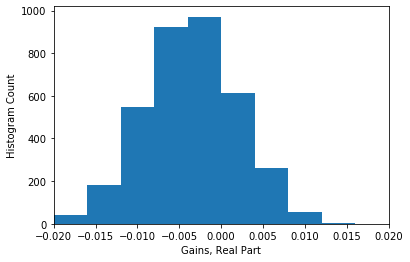

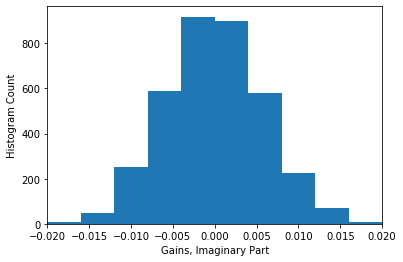

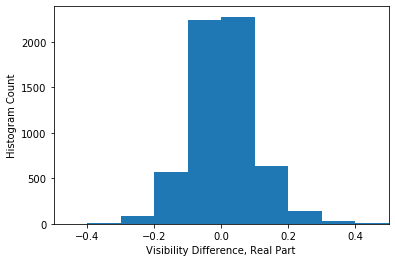

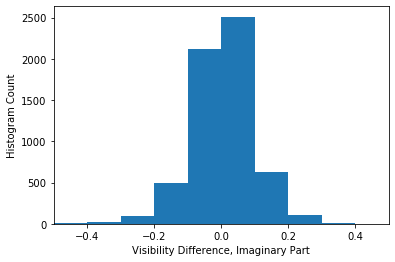

In [13]:
gain_vals = np.zeros((data_sim.Nants_data, n_trials), dtype=np.complex_)
vis_diff_vals = np.zeros((np.shape(baseline_groups)[0], n_trials), dtype=np.complex_)

for trial in range(n_trials):
    data_visibilities = data_vis_noisy[:, trial]
    
    result = scipy.optimize.minimize(
        cost_function, x0, 
        args=(
            np.shape(baseline_groups)[0], data_sim.Nants_data, baseline_cov_inv, 
            model_sim_visibilities, a_mat, gains_exp_mat_1, gains_exp_mat_2, data_visibilities, data_stddev, model_stddev_sim
        ),
        method=method, options={'maxiter':maxiter}
    )
    #print(result.message)
    gains_fit = result.x[:data_sim.Nants_data]+1j*result.x[data_sim.Nants_data:2*data_sim.Nants_data]
    # Ensure that the average angle is zero
    avg_angle = np.arctan2(np.mean(np.sin(np.angle(gains_fit))), np.mean(np.cos(np.angle(gains_fit))))
    gains_fit *= np.cos(avg_angle) - 1j*np.sin(avg_angle)
    gain_vals[:, trial] = gains_fit-1
    vis_fit = result.x[-2*np.shape(baseline_groups)[0]:-np.shape(baseline_groups)[0]]+1j*result.x[-np.shape(baseline_groups)[0]:]
    vis_fit_diff = vis_fit-model_visibilities_no_noise
    vis_diff_vals[:, trial] = vis_fit_diff

print(np.mean(np.abs(gain_vals)))
print(np.mean(np.abs(vis_diff_vals)))

unified_cal_gains = gain_vals
unified_cal_vis = vis_diff_vals

plot_range = .02
nbins = 10
bins = np.linspace(-plot_range, plot_range, num=nbins+1)

plt.hist(np.real(gain_vals).flatten(), bins=bins)
plt.xlabel('Gains, Real Part')
plt.ylabel('Histogram Count')
plt.xlim(-plot_range,plot_range)
plt.show()

plt.hist(np.imag(gain_vals).flatten(), bins=bins)
plt.xlabel('Gains, Imaginary Part')
plt.ylabel('Histogram Count')
plt.xlim(-1*plot_range, plot_range)
plt.show()

plot_range = .5
bins = np.linspace(-plot_range, plot_range, num=nbins+1)

plt.hist(np.real(vis_diff_vals).flatten(), bins=bins)
plt.xlabel('Visibility Difference, Real Part')
plt.ylabel('Histogram Count')
plt.xlim(-1*plot_range, plot_range)
plt.show()

plt.hist(np.imag(vis_diff_vals).flatten(), bins=bins)
plt.xlabel('Visibility Difference, Imaginary Part')
plt.ylabel('Histogram Count')
plt.xlim(-1*plot_range, plot_range)
plt.show()

0.013069604712638988
0.16782703871352647


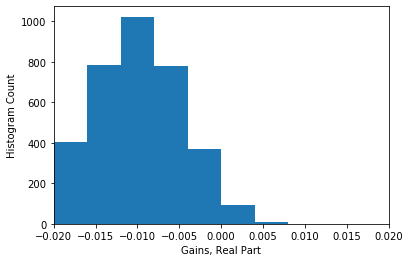

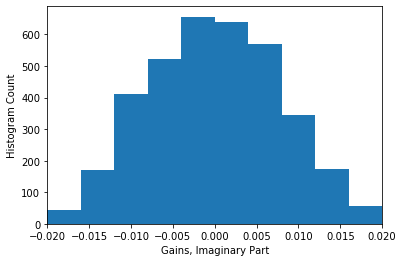

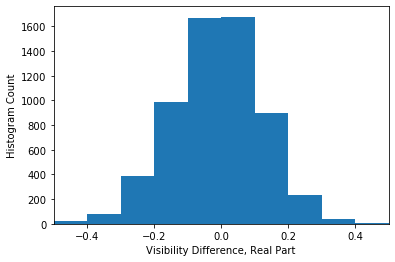

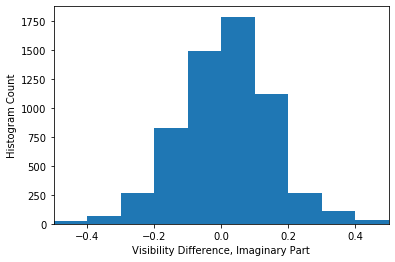

In [14]:
gain_vals = np.zeros((data_sim.Nants_data, n_trials), dtype=np.complex_)
vis_diff_vals = np.zeros((np.shape(baseline_groups)[0], n_trials), dtype=np.complex_)

for trial in range(n_trials):
    data_visibilities = data_vis_noisy[:, trial]
    
    result = scipy.optimize.minimize(
        cost_function, x0, 
        args=(
            np.shape(baseline_groups)[0], data_sim.Nants_data, baseline_cov_inv, 
            model_sim_visibilities, a_mat, gains_exp_mat_1, gains_exp_mat_2, data_visibilities, data_stddev, model_stddev_sim*100000
        ),
        method=method, options={'maxiter':maxiter}
    )
    #print(result.message)
    gains_fit = result.x[:data_sim.Nants_data]+1j*result.x[data_sim.Nants_data:2*data_sim.Nants_data]
    # Ensure that the average angle is zero
    avg_angle = np.arctan2(np.mean(np.sin(np.angle(gains_fit))), np.mean(np.cos(np.angle(gains_fit))))
    gains_fit *= np.cos(avg_angle) - 1j*np.sin(avg_angle)
    gain_vals[:, trial] = gains_fit-1
    vis_fit = result.x[-2*np.shape(baseline_groups)[0]:-np.shape(baseline_groups)[0]]+1j*result.x[-np.shape(baseline_groups)[0]:]
    vis_fit_diff = vis_fit-model_visibilities_no_noise
    vis_diff_vals[:, trial] = vis_fit_diff

print(np.mean(np.abs(gain_vals)))
print(np.mean(np.abs(vis_diff_vals)))

red_cal_gains = gain_vals
red_cal_vis = vis_diff_vals

plot_range = .02
nbins = 10
bins = np.linspace(-plot_range, plot_range, num=nbins+1)

plt.hist(np.real(gain_vals).flatten(), bins=bins)
plt.xlabel('Gains, Real Part')
plt.ylabel('Histogram Count')
plt.xlim(-plot_range,plot_range)
plt.show()

plt.hist(np.imag(gain_vals).flatten(), bins=bins)
plt.xlabel('Gains, Imaginary Part')
plt.ylabel('Histogram Count')
plt.xlim(-1*plot_range, plot_range)
plt.show()

plot_range = .5
bins = np.linspace(-plot_range, plot_range, num=nbins+1)

plt.hist(np.real(vis_diff_vals).flatten(), bins=bins)
plt.xlabel('Visibility Difference, Real Part')
plt.ylabel('Histogram Count')
plt.xlim(-1*plot_range, plot_range)
plt.show()

plt.hist(np.imag(vis_diff_vals).flatten(), bins=bins)
plt.xlabel('Visibility Difference, Imaginary Part')
plt.ylabel('Histogram Count')
plt.xlim(-1*plot_range, plot_range)
plt.show()

0.013119076096621983
0.5030445850711496


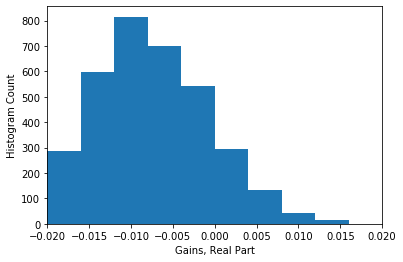

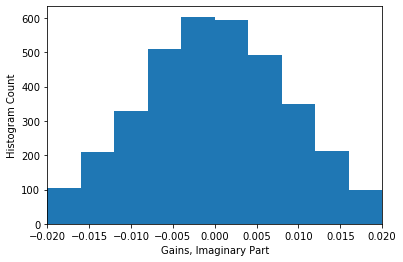

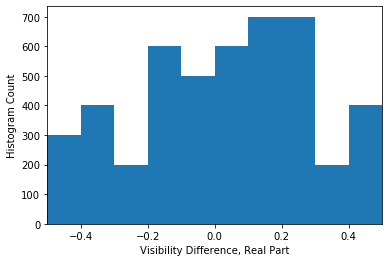

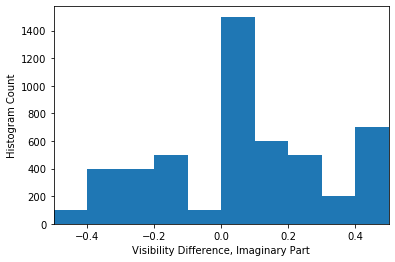

In [15]:
gain_vals = np.zeros((data_sim.Nants_data, n_trials), dtype=np.complex_)
vis_diff_vals = np.zeros((np.shape(baseline_groups)[0], n_trials), dtype=np.complex_)

for trial in range(n_trials):
    data_visibilities = data_vis_noisy[:, trial]
    
    result = scipy.optimize.minimize(
        cost_function, x0, 
        args=(
            np.shape(baseline_groups)[0], data_sim.Nants_data, baseline_cov_inv, 
            model_sim_visibilities, a_mat, gains_exp_mat_1, gains_exp_mat_2, data_visibilities, data_stddev, model_stddev_sim/100000
        ),
        method=method, options={'maxiter':maxiter}
    )
    #print(result.message)
    gains_fit = result.x[:data_sim.Nants_data]+1j*result.x[data_sim.Nants_data:2*data_sim.Nants_data]
    # Ensure that the average angle is zero
    avg_angle = np.arctan2(np.mean(np.sin(np.angle(gains_fit))), np.mean(np.cos(np.angle(gains_fit))))
    gains_fit *= np.cos(avg_angle) - 1j*np.sin(avg_angle)
    gain_vals[:, trial] = gains_fit-1
    vis_fit = result.x[-2*np.shape(baseline_groups)[0]:-np.shape(baseline_groups)[0]]+1j*result.x[-np.shape(baseline_groups)[0]:]
    vis_fit_diff = vis_fit-model_visibilities_no_noise
    vis_diff_vals[:, trial] = vis_fit_diff

print(np.mean(np.abs(gain_vals)))
print(np.mean(np.abs(vis_diff_vals)))

sky_cal_gains = gain_vals
sky_cal_vis = vis_diff_vals

plot_range = .02
nbins = 10
bins = np.linspace(-plot_range, plot_range, num=nbins+1)

plt.hist(np.real(gain_vals).flatten(), bins=bins)
plt.xlabel('Gains, Real Part')
plt.ylabel('Histogram Count')
plt.xlim(-plot_range,plot_range)
plt.show()

plt.hist(np.imag(gain_vals).flatten(), bins=bins)
plt.xlabel('Gains, Imaginary Part')
plt.ylabel('Histogram Count')
plt.xlim(-1*plot_range, plot_range)
plt.show()

plot_range = .5
bins = np.linspace(-plot_range, plot_range, num=nbins+1)

plt.hist(np.real(vis_diff_vals).flatten(), bins=bins)
plt.xlabel('Visibility Difference, Real Part')
plt.ylabel('Histogram Count')
plt.xlim(-1*plot_range, plot_range)
plt.show()

plt.hist(np.imag(vis_diff_vals).flatten(), bins=bins)
plt.xlabel('Visibility Difference, Imaginary Part')
plt.ylabel('Histogram Count')
plt.xlim(-1*plot_range, plot_range)
plt.show()

In [16]:
def produce_kde(data, xvals, yvals):
    
    data_real = np.real(data).flatten()
    data_imag = np.imag(data).flatten()
    rvs = np.append(data_real[:,np.newaxis],
                    data_imag[:,np.newaxis],
                    axis=1)

    kde = scipy.stats.kde.gaussian_kde(rvs.T)

    # Regular grid to evaluate KDE upon
    x,y = np.meshgrid(xvals, yvals)
    grid_coords = np.append(x.reshape(-1,1),y.reshape(-1,1),axis=1)

    kde_vals = kde(grid_coords.T)
    kde_vals = kde_vals.reshape(len(xvals),len(yvals))
    
    percent_vals = np.zeros_like(kde_vals)
    kde_total = np.sum(kde_vals)
    running_total = 0.
    for val in np.sort(kde_vals.flatten())[::-1]: # Sort values in reverse order
        percent_vals[np.where(kde_vals == val)] = running_total/kde_total
        running_total += val
    
    return kde_vals, percent_vals

In [22]:
matplotlib.rcParams.update({'font.size': 20})

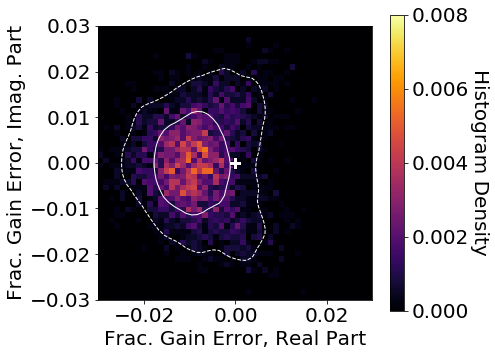

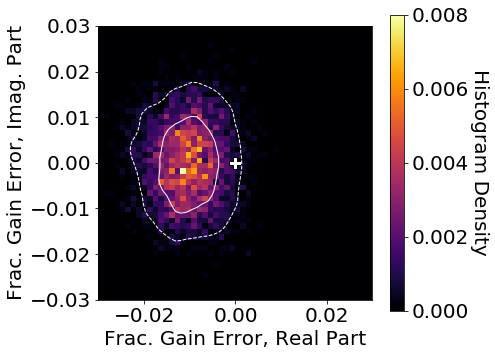

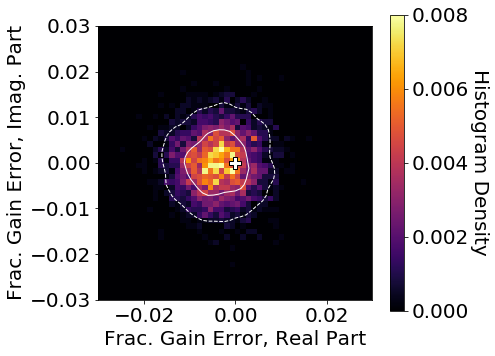

In [33]:
plot_range = .03
nbins = 50
bins = np.linspace(-plot_range, plot_range, num=nbins+1)
colorbar_range = [0, .008]

data_sets = [sky_cal_gains, red_cal_gains, unified_cal_gains]
data_titles = [
    'Gains Error, Sky-Based Style Calibration',
    'Gains Error, Redundant Style Calibration',
    'Gains Error, Unified Style Calibration'
]
save_path = '/Users/ruby/Downloads'
save_names = ['gains_sky_cal.png', 'gains_red_cal.png', 'gains_unified_cal.png']

for data_set_ind in range(len(data_sets)):

    hist, x_edges, y_edges = np.histogram2d(
        np.real(data_sets[data_set_ind]).flatten(), np.imag(data_sets[data_set_ind]).flatten(), bins=bins
    )
    hist /= np.sum(hist)

    kde, percent_plot = produce_kde(data_sets[data_set_ind], bins, bins)

    plt.figure(figsize=[7,5.5])
    plt.imshow(
        hist.T, interpolation='none', origin='lower',
        extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
        vmin=colorbar_range[0], vmax=colorbar_range[1], aspect='equal',
        cmap='inferno'
    )
    cbar = plt.colorbar(cmap='inferno')
    cbar.ax.set_ylabel('Histogram Density', rotation=270, labelpad=20)
    cont = plt.contour(bins, bins, percent_plot, levels=[.5,.9], colors='white', linestyles=['solid','dashed'], linewidths=1)
    plt.scatter([0],[0],marker='P',color='white',edgecolors='black',s=150)
    #plt.clabel(cont, inline=2, fontsize=10)
    plt.xlabel('Frac. Gain Error, Real Part')
    plt.ylabel('Frac. Gain Error, Imag. Part')
    #plt.title(data_titles[data_set_ind])
    plt.tight_layout() # Ensure that axes labels don't get cut off
    plt.savefig('{}/{}'.format(save_path, save_names[data_set_ind]),dpi=600)
    plt.show()

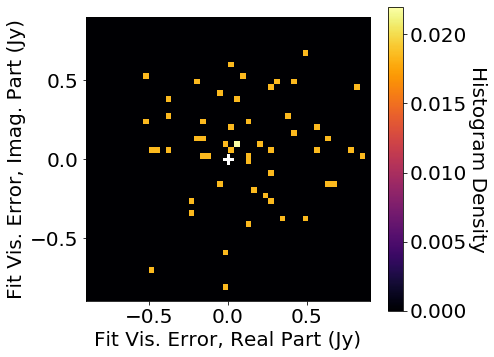

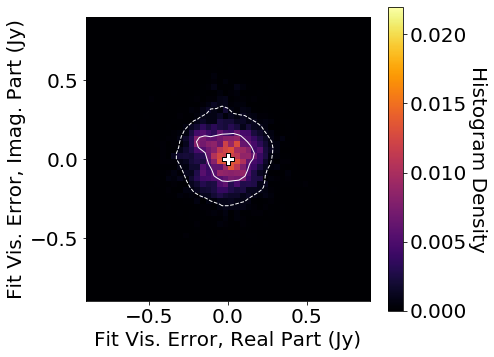

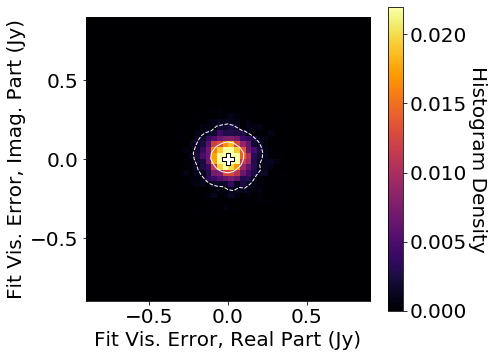

In [37]:
plot_range = .9
nbins = 50
bins = np.linspace(-plot_range, plot_range, num=nbins+1)
colorbar_range = [0, .022]

data_sets = [sky_cal_vis, red_cal_vis, unified_cal_vis]
data_titles = [
    'Visibility Error, Sky-Based Style Calibration',
    'Visibility Error, Redundant Style Calibration',
    'Visibility Error, Unified Style Calibration'
]
save_path = '/Users/ruby/Downloads'
save_names = ['vis_sky_cal.png', 'vis_red_cal.png', 'vis_unified_cal.png']

for data_set_ind in range(len(data_sets)):

    hist, x_edges, y_edges = np.histogram2d(
        np.real(data_sets[data_set_ind]).flatten(), np.imag(data_sets[data_set_ind]).flatten(), bins=bins
    )
    hist /= np.sum(hist)

    kde, percent_plot = produce_kde(data_sets[data_set_ind], bins, bins)

    plt.figure(figsize=[7,5.5])
    plt.imshow(
        hist.T, interpolation='none', origin='lower',
        extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
        vmin=colorbar_range[0], vmax=colorbar_range[1], aspect='equal',
        cmap='inferno'
    )
    cbar = plt.colorbar(cmap='inferno')
    cbar.ax.set_ylabel('Histogram Density', rotation=270, labelpad=20)
    if data_set_ind != 0: # Don't plot contours for sky cal
        cont = plt.contour(bins, bins, percent_plot, levels=[.5,.9], colors='white', linestyles=['solid','dashed'], linewidths=1)
    plt.scatter([0],[0],marker='P',color='white',edgecolors='black',s=150)
    #plt.clabel(cont, inline=1, fontsize=10)
    plt.xlabel('Fit Vis. Error, Real Part (Jy)')
    plt.ylabel('Fit Vis. Error, Imag. Part (Jy)')
    #plt.title(data_titles[data_set_ind])
    plt.tight_layout()
    plt.savefig('{}/{}'.format(save_path, save_names[data_set_ind]), dpi=600)
    plt.show()

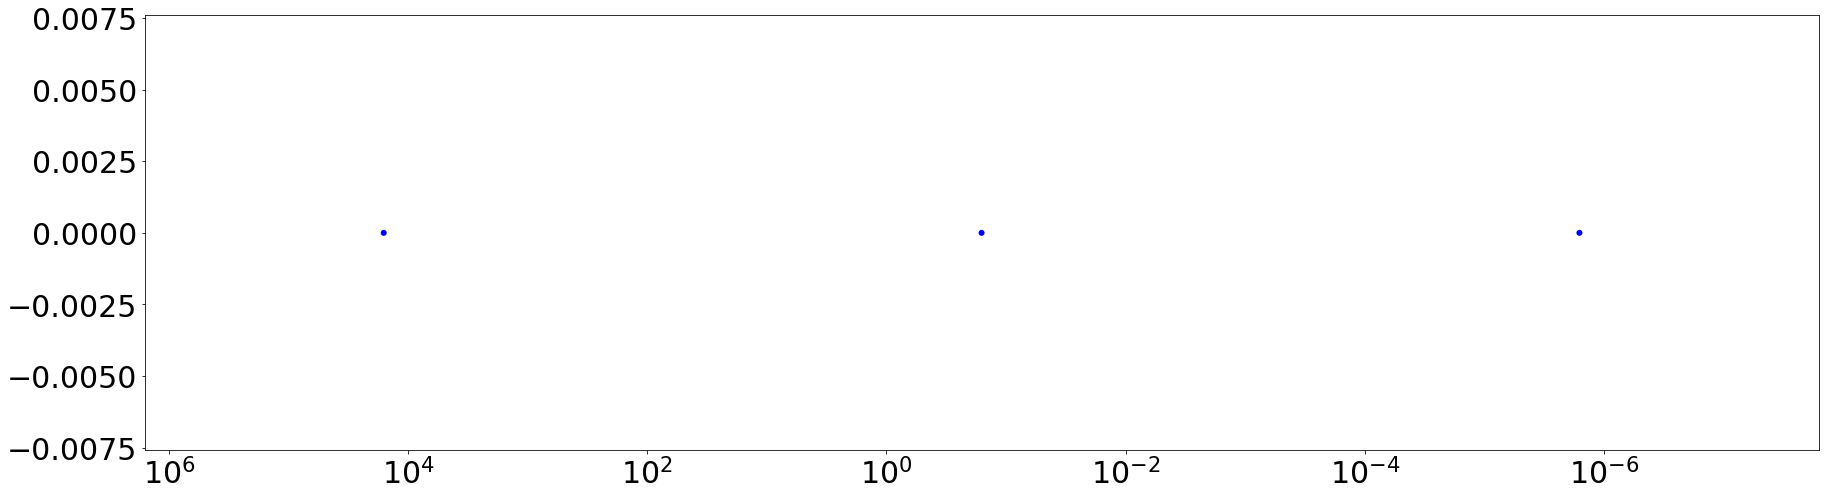

In [20]:
matplotlib.rcParams.update({'font.size': 30})
fig = plt.figure(figsize=[30,8])
ax = plt.gca()
ax.scatter([.16/100000, .16, .16*100000], [0,0,0], c='blue', edgecolors='none')
ax.set_xscale('log')
#plt.xlim((.16/100000)*1e-2,.16*100000*1e2)
plt.xlim(.16*100000*1e2, (.16/100000)*1e-2)

save_path = '/Users/ruby/Downloads'
plt.savefig('{}/x_axis'.format(save_path), dpi=600)

plt.show()